In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import combinations
import csv
from scipy.signal import resample_poly
from scipy.stats import pearsonr
from scipy.spatial.transform import Rotation as R

from pathlib import Path
import glob
import shutil
import os
import pickle


import sys
sys.path.append('/storage3/eva/code/neuropixels/src')
import path_formatting as pf
import motive
import oe

In [2]:
date = "20250718" # change this according to ur session
animal = "eb02"

oe_sr = 30000
m_sr = 120

csv_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\motive\out_csv'
csv_path = pf.w2l(csv_path)

res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
res_path_path = Path(res_path)
os.makedirs(res_path, exist_ok=True) # Create the folder if it doesn't exist

csv_path, res_path

('/storage3/eva/data/processed/eb02/eb02_20250718/motive/out_csv',
 '/storage3/eva/code/neuropixels/results/eb02/eb02_20250718')

In [3]:
trial_key = 'of1' # here u select ur trial of interest
speed_cutoff = 0.02 # 2cm/s

In [4]:
csv_dict = motive.get_csv_dict(csv_path)
csv_dict.keys()

dict_keys(['20250718_1', '20250718_2', '20250718_3', '20250718_4', '20250718_5', '20250718_6', '20250718_7'])

In [5]:
res_path_path = Path(res_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)
periods

{'sl1': [np.int64(130065), np.int64(110322388)],
 'of1': [np.int64(110737904), np.int64(165816048)],
 'sl2': [np.int64(166190417), np.int64(274253428)],
 'of2': [np.int64(274558716), np.int64(329170625)],
 'sl3': [np.int64(329455963), np.int64(437766820)],
 'of3': [np.int64(438175313), np.int64(500947727)],
 'sl4': [np.int64(501330215), np.int64(609931857)]}

In [6]:
csv_keys = list(csv_dict.keys())
csv_keys = sorted(csv_keys, key=lambda x: int(x.split('_')[1]))
oe_keys = list(periods.keys())
meta = dict(zip(oe_keys, csv_keys))
meta

{'sl1': '20250718_1',
 'of1': '20250718_2',
 'sl2': '20250718_3',
 'of2': '20250718_4',
 'sl3': '20250718_5',
 'of3': '20250718_6',
 'sl4': '20250718_7'}

In [7]:
trial_key

'of1'

In [8]:
trial = meta[trial_key]
df = csv_dict[trial]

In [9]:
frame_times = motive.get_frame_times(df)

In [10]:
df.iloc[:7,:]

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,Format Version,1.21,Take Name,Take 2025-07-18 01.41.56 PM,Capture Frame Rate,120.000046,Export Frame Rate,120.000046,Capture Start Time,2025-07-18 01.41.56.441 PM,...,None,None,None,None,None,None,None,None,None,None
1,,,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,...,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker,Rigid Body Marker
2,,,TOF,TOF,TOF,TOF,TOF,TOF,TOF,TOF,...,rat_v2_4,rat_v2_4,rat_v2_5,rat_v2_5,rat_v2_5,rat_v2_5,rat_v2_6,rat_v2_6,rat_v2_6,rat_v2_6
3,,,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,F581C9785DBC11F0AE1655181000018E,...,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2,124ECBEC602511F0AE165518100029A2
4,,,Rotation,Rotation,Rotation,Rotation,Position,Position,Position,Error Per Marker,...,Position,Marker Quality,Position,Position,Position,Marker Quality,Position,Position,Position,Marker Quality
5,Frame,Time,X,Y,Z,W,X,Y,Z,,...,Z,,X,Y,Z,,X,Y,Z,
6,0,0.000000,-0.000211,-0.025550,0.000036,-0.999674,0.033875,0.485259,0.079113,0.001296,...,-0.270599,0.959527,-0.030692,0.002624,-0.251566,0.000000,-0.039731,0.034166,-0.238707,0.899788


## Fixing stuff

### 0. Data load

In [12]:
trial_key = 'of1'
csv_dict = motive.get_csv_dict(csv_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)
of_keys = list(periods.keys())[1::2] # ['of1', 'of2', 'of3']
motive_keys = [f'{date}_2',f'{date}_4',f'{date}_6']
meta = dict(zip(of_keys, motive_keys))
trial = meta[trial_key]
df = csv_dict[trial]

In [33]:
t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
z = arrays_interpol['Z']
_,_,v = motive.speed(arrays_interpol['X'], arrays_interpol['Z'], t)

qt = ['X','Y','Z','W']
qt_arrays, qt_arrays_interpol = motive.get_arrays(df, metric='Rotation', dim_array = qt, interpolate=True)
for r in qt:
    print(r,np.isnan(qt_arrays[r]).sum(), 'nans')

X 1243 nans
Y 1243 nans
Z 1243 nans
W 1243 nans


### 1. Conversion: qt --> eul

X → left  
Y → up  
Z → forward

In [14]:
def plot_jpdf_euler_height(y, roll, pitch, yaw, bins=50):
    """
    Plot joint PDFs of each Euler angle vs height, with Euler angles on x-axis.
    
    y      : array-like, height values
    roll   : array-like, roll angles (rad or deg)
    pitch  : array-like, pitch angles (rad or deg)
    yaw    : array-like, yaw angles (rad or deg)
    bins   : int or [int, int], number of bins for histogram2d
    """
    angles = [roll, pitch, yaw]
    names = ['Roll', 'Pitch', 'Yaw']

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for ax, ang, name in zip(axs, angles, names):
        # Now: angle is x-axis, height is y-axis
        H, xedges, yedges = np.histogram2d(ang, y, bins=bins, density=True)
        X, Y = np.meshgrid(xedges, yedges)
        pcm = ax.pcolormesh(X, Y, H.T, cmap='jet')
        ax.set_xlabel(f'{name} angle')
        ax.set_ylabel('Height')
        fig.colorbar(pcm, ax=ax, label='Density')

    plt.tight_layout()
    plt.show()

In [15]:
def yaw_speed(yaw, x,z):
    fig,axs = plt.subplots(1, 1, figsize=(4,4))
    d = -np.arctan2(np.diff(z), np.diff(x))
    direction = np.append(d, d[-1])
    v[v > 0.2] = 0.2 # for visualization
    
    this_plot = axs.scatter(yaw, direction, c=v, s=0.1, cmap='rainbow', alpha=0.5)
    axs.plot([-180, 180], [-np.pi, np.pi], 'k--', label='y=x')
    axs.set_xlabel('Yaw(ry)', fontsize=12)
    axs.set_ylabel('Movement Direction', fontsize=12)
    axs.legend()
    fig.colorbar(this_plot, ax=axs, label='Speed (m/s)', fraction=0.046, pad=0.04)

    fig.suptitle('Moving Direction versus Yaw(ry)', fontsize=16)
    fig.tight_layout()
    plt.show()

In [16]:
def hists(roll, pitch, yaw):
    eu_angles = ['roll', 'pitch', 'yaw']
    fig, axs = plt.subplots(1, 3, figsize=(9,3))
    axs = axs.flatten()
    for i, eu in enumerate([roll, pitch, yaw]):
        ax = axs[i]
        ax.hist(eu, bins=100)
        ax.set_title(eu_angles[i])
    plt.tight_layout()
    plt.show()

In [17]:
from scipy.spatial.transform import Rotation as R

In [18]:
# quaternions : array of shape (N, 4) in (x, y, z, w) format
quaternions = np.array([
    qt_arrays_interpol['X'], 
    qt_arrays_interpol['Y'], 
    qt_arrays_interpol['Z'],
    qt_arrays_interpol['W']
    ]).T
quaternions.shape

(220314, 4)

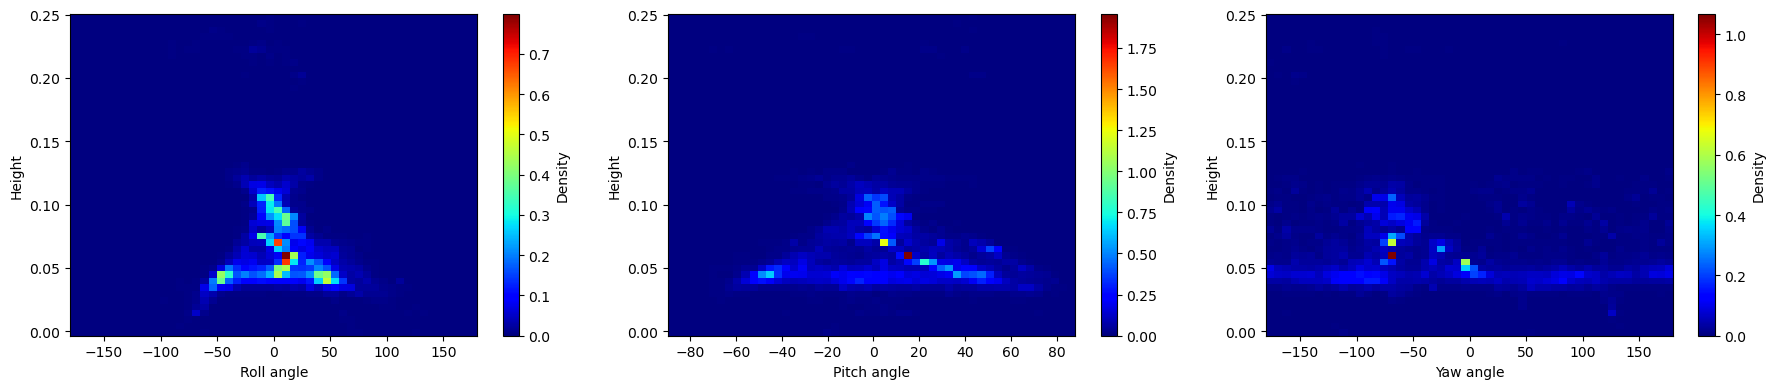

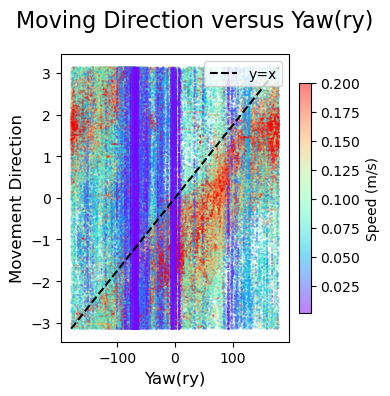

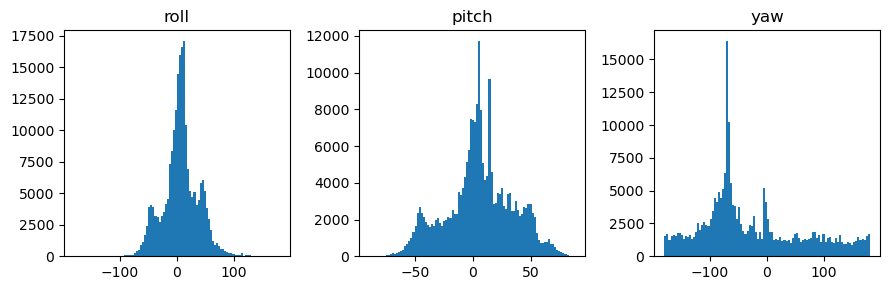

In [19]:
# to intrinsic
eulers = R.from_quat(quaternions).as_euler('ZXY', degrees=True)
roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]

plot_jpdf_euler_height(y,roll, pitch, yaw)
yaw_speed(yaw, x,z)
hists(roll, pitch, yaw)

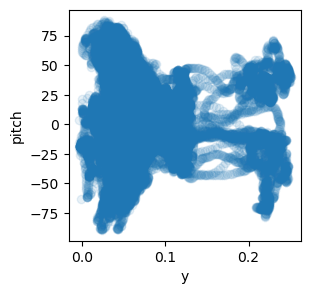

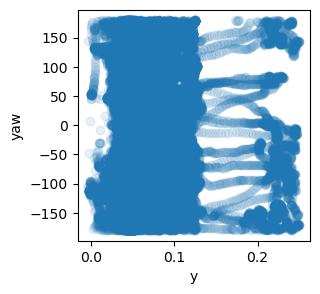

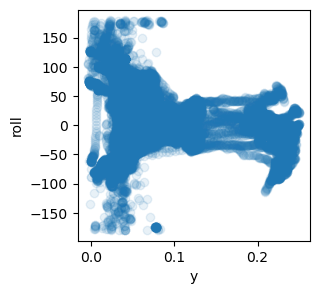

In [20]:
plt.figure(figsize=(3,3))
plt.scatter(y,pitch, alpha=0.1)
plt.xlabel('y'); plt.ylabel('pitch')
plt.show()

plt.figure(figsize=(3,3))
plt.scatter(y,yaw, alpha=0.1)
plt.xlabel('y'); plt.ylabel('yaw')
plt.show()

plt.figure(figsize=(3,3))
plt.scatter(y,roll, alpha=0.1)
plt.xlabel('y'); plt.ylabel('roll')
plt.show()

[]

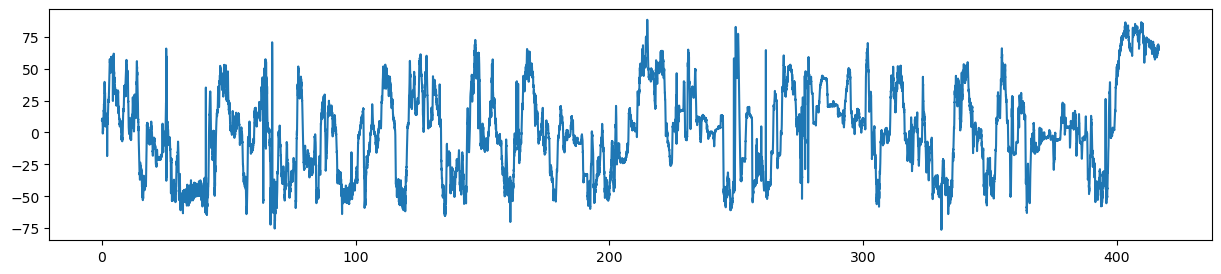

In [31]:
# since this makes more sense for me i ll use it! fml
plt.figure(figsize=(15,3))
plt.plot(frame_times[:50000], pitch[:50000])
plt.plot()

In [30]:
# from scipy.ndimage import gaussian_filter1d

# fs = 120  # Hz
# sigma_time = 0.5  # 500 ms smoothing
# sigma_frames = int(sigma_time * fs)

# pitch_smooth = gaussian_filter1d(pitch, sigma=sigma_frames)

# plt.figure(figsize=(15,3))
# plt.plot(frame_times[:50000], pitch_smooth[:50000])
# plt.plot()

In [23]:
np.min(pitch_smooth), np.max(pitch_smooth)

(np.float64(-66.243716212697), np.float64(71.5937942376241))

here i do for all OF in batch

In [24]:
qt = ['X','Y','Z','W']
of_keys = ['of1', 'of2', 'of3']
motive_keys = [f'{date}_2',f'{date}_4',f'{date}_6']
meta = dict(zip(of_keys, motive_keys))

In [25]:
smooth_pitch_dict = {}
for of in of_keys:
    df = csv_dict[meta[of]]
    _, qt_arrays_interpol = motive.get_arrays(df, metric='Rotation', dim_array = qt, interpolate=True)
    quaternions = np.array([
        qt_arrays_interpol['X'], 
        qt_arrays_interpol['Y'], 
        qt_arrays_interpol['Z'],
        qt_arrays_interpol['W']
        ]).T
    eulers = R.from_quat(quaternions).as_euler('ZXY', degrees=True)
    roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]
    fs = 120  # Hz
    sigma_time = 0.5  # 500 ms smoothing
    sigma_frames = int(sigma_time * fs)
    pitch_smooth = gaussian_filter1d(pitch, sigma=sigma_frames)    
    smooth_pitch_dict[of] = pitch_smooth 

In [26]:
res_path_path = Path(res_path)

with open(res_path_path/"smooth_pitch_dict.pkl", "wb") as f:
    pickle.dump(smooth_pitch_dict, f)

In [28]:
x.shape, z.shape

((220314,), (220314,))

In [29]:
y.shape, roll.shape

((220314,), (251091,))

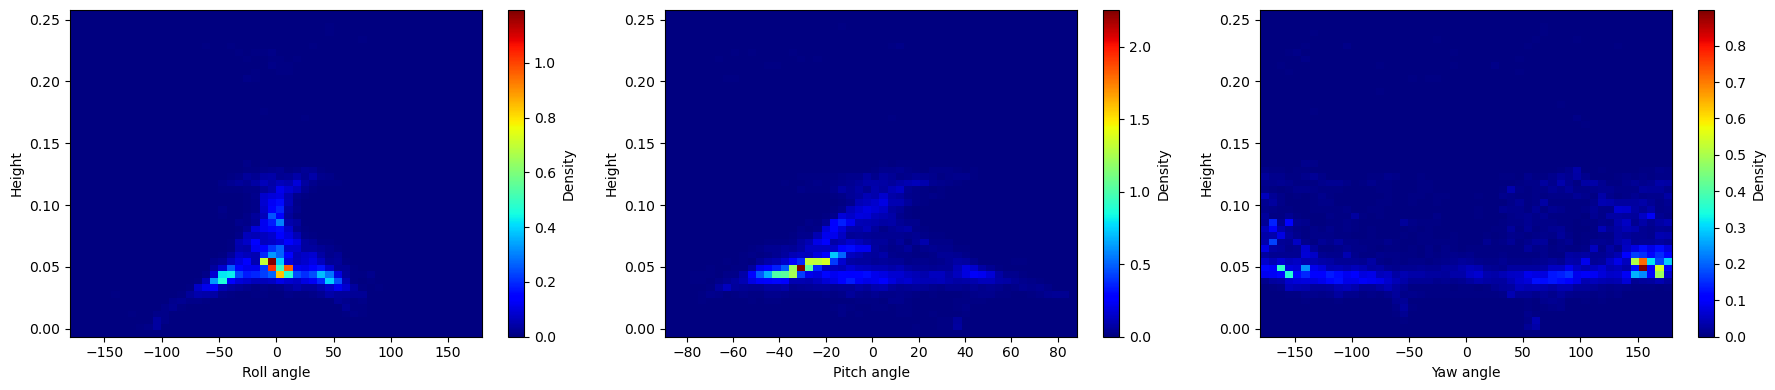

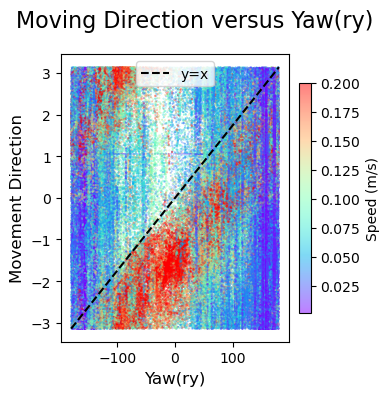

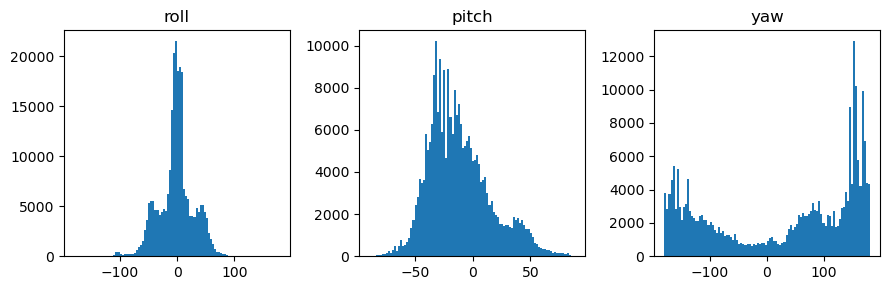

In [35]:
# to extrinsic
eulers = R.from_quat(quaternions).as_euler('yxz', degrees=True)
yaw, pitch, roll = eulers[:, 0], eulers[:, 1], eulers[:, 2]

plot_jpdf_euler_height(y,roll, pitch, yaw)
yaw_speed(yaw, x,z)
hists(roll, pitch, yaw)

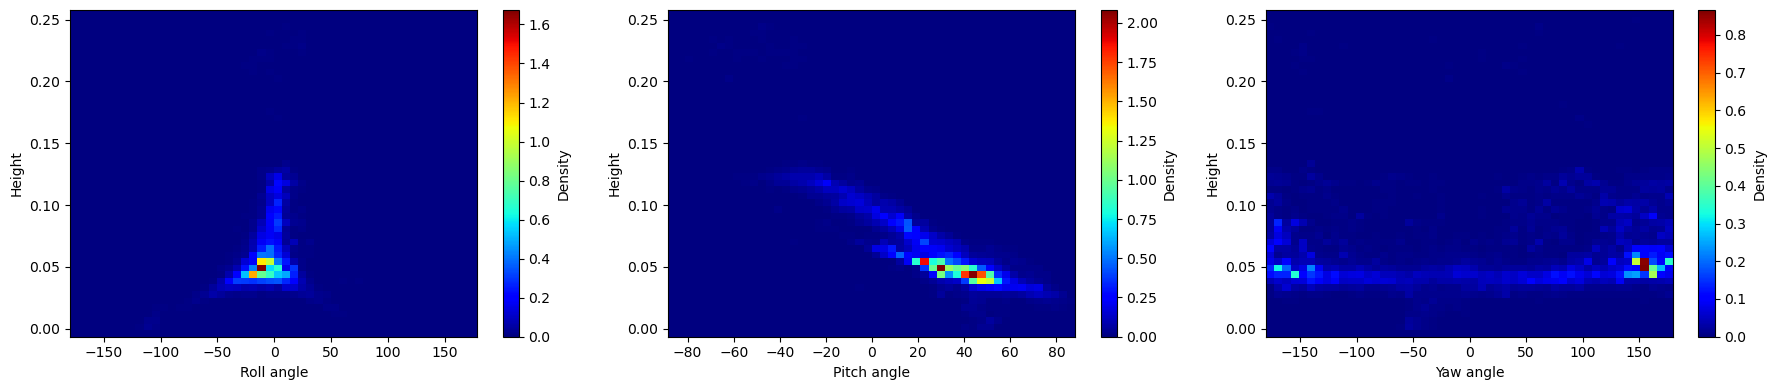

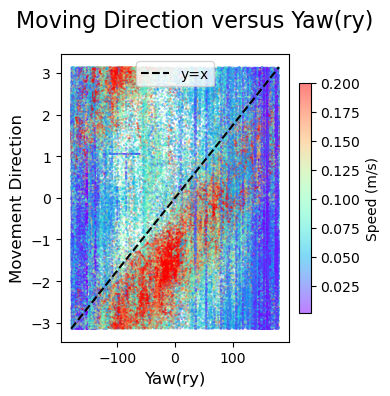

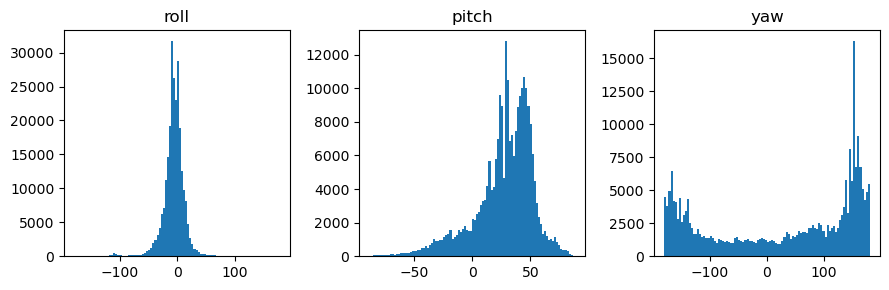

In [37]:
# to extrinsic
eulers = R.from_quat(quaternions).as_euler('zxy', degrees=True)
roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]

plot_jpdf_euler_height(y,roll, pitch, yaw)
yaw_speed(yaw, x,z)
hists(roll, pitch, yaw)

## explote other combos

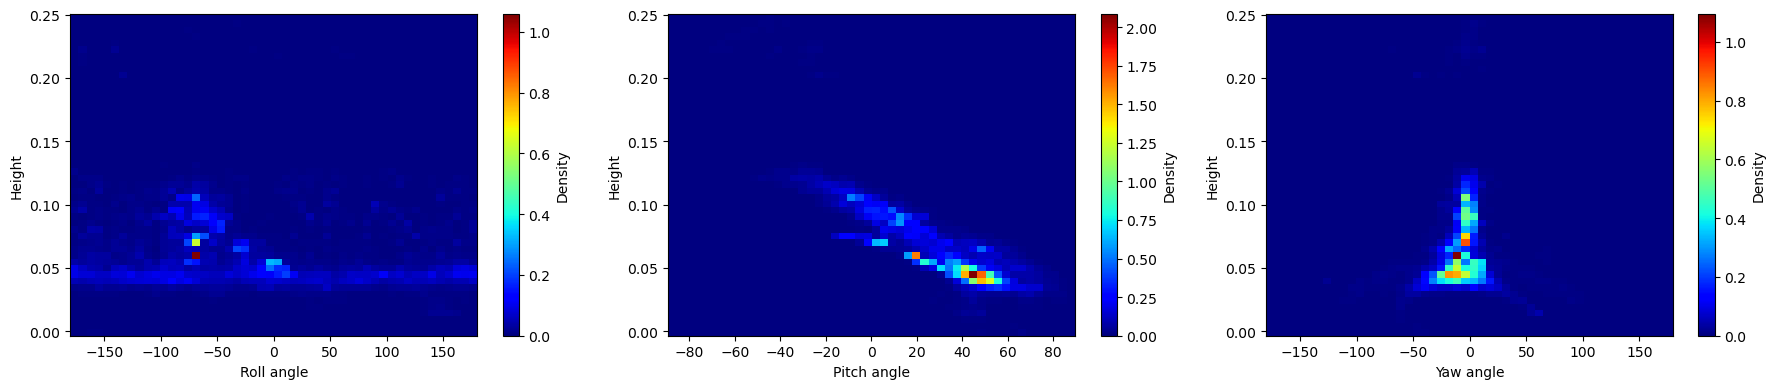

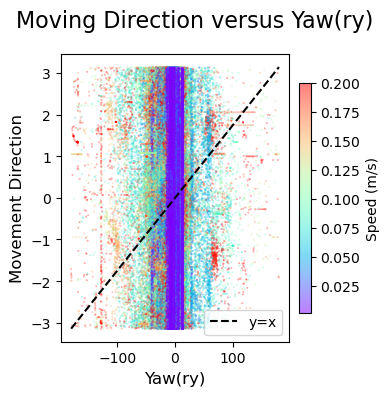

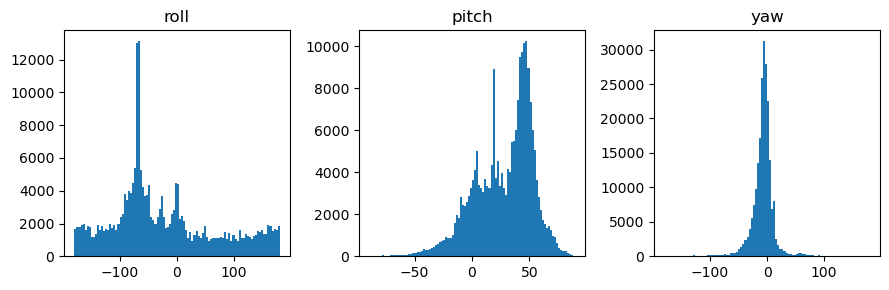

In [ ]:
eulers = R.from_quat(quaternions).as_euler('YXZ', degrees=True)
roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]

plot_jpdf_euler_height(y,roll, pitch, yaw)
yaw_speed(yaw, x,z)
hists(roll, pitch, yaw)

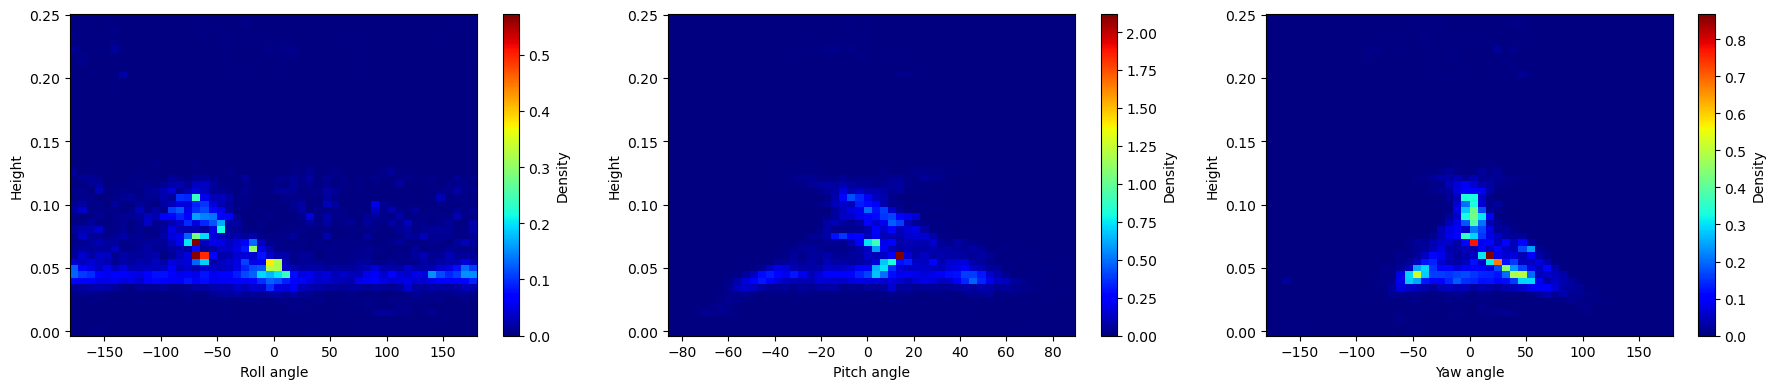

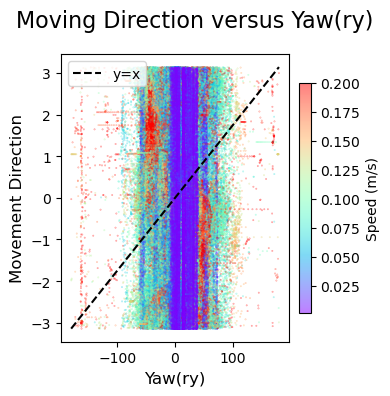

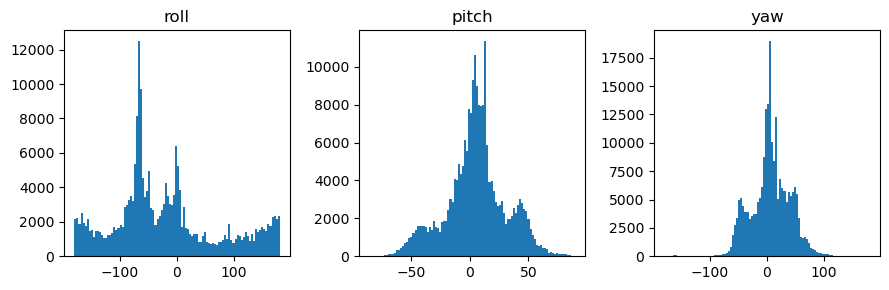

In [ ]:
quat = np.array([
    qt_arrays_interpol['Z'], 
    qt_arrays_interpol['Y'], 
    qt_arrays_interpol['X'],
    qt_arrays_interpol['W']
    ]).T

eulers = R.from_quat(quat).as_euler('YXZ', degrees=True)
roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]

plot_jpdf_euler_height(y,roll, pitch, yaw)
yaw_speed(yaw, x,z)
hists(roll, pitch, yaw)